# Optimizacion del k de kNN con weights distance_pow


## Buildear

In [ ]:
!cd .. && ./build.sh

## Carga de datos

In [46]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")
df_train.info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [47]:
df_train.sample(frac=1)
df_train = df_train[:5000]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 29.9 MB


In [48]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

### Optimizacion de k con simmulated annealing

In [53]:
import metnum

import numpy.random as rn
import numpy as np

from scoring import cross_validation as cv
from scoring import metrics

k_range = (1, 100)
T = 100

## Funciones parametro de simm ann

def clip_k(k):
    """Le pasas el state y lo pone en el rango valido"""
    a, b = k_range
    
    return max(a,min(b,int(k)))

def random_start():
    """Elige un state start aleatorio"""
    a, b = k_range
    rnd_k = a + (b - a) * rn.random_sample()
    return clip_k(rnd_k)

def random_neighbour(actual_k, fraction=0.0):
    """
    Varia un poco el estado actual para moverse en el espacio
    y probar una solucion distinta.
    """
    a, b = k_range
    new_k = actual_k
    
    while new_k == actual_k and fraction != 1.0:
        delta = int((b - a) * (0.5-rn.random_sample()) * (1.0-fraction))
        new_k = clip_k(actual_k + delta)
        
    return new_k

def acceptance_probability(cost, new_cost, temperature):
    """Probabilidad de aceptar una solucion como la nueva mejor"""
    if new_cost > cost: # cost en nuestro caso va a ser scoring
        # Si la solucion nueva es mejor que la anterior
        # la tomamos como la nueva mejor siempre.
        return 1

    p = np.exp(- ( cost - new_cost) / temperature)
    return p

def change_temperature(fraction):
    """Cuanto estas buscando soluciones"""
    return T*(1-fraction)


In [ ]:
from metaheuristics import simulated_annealing as sa

K = 4

def scoring(k):
    # classifier a optimiazr
    clf = metnum.KNNClassifier(k, "distance_pow")
    accuracy = cv.cross_validate(clf, X, y, metrics.accuracy_score, K)
    return accuracy

best_state, history = sa.annealing(
    random_start,
    scoring,
    random_neighbour,
    acceptance_probability,
    change_temperature,
    max_state_reset_steps=50,
    max_steps=10,
    debug=True,
)

# Save history in df
df = pd.DataFrame(history, columns=["step", "state", "score", "best"])

  0%|          | 0/9 [00:00<?, ?it/s]

initial: state = 54, score = 0.8982


 56%|█████▌    | 5/9 [01:23<01:06, 16.65s/it]

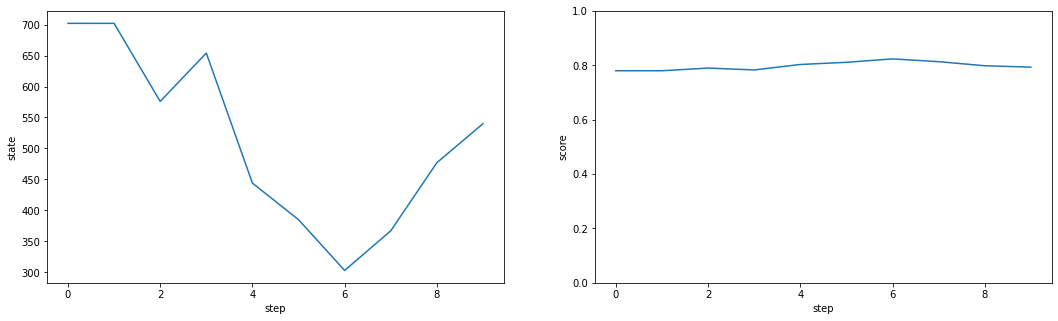

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, (ax_state, ax_score) = plt.subplots(1, 2, figsize=(18, 5))
ax_score.set_ylim(0, 1)
plot = sns.lineplot(data=df, x="step", y="state", ax=ax_state)
plot = sns.lineplot(data=df, x="step", y="score", ax=ax_score)

(0.945, 0.98)

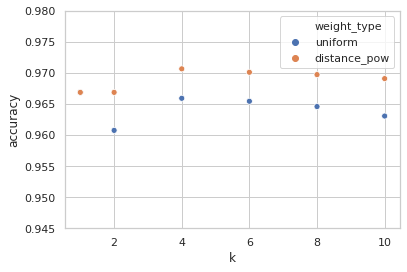

In [9]:
import seaborn as sns
sns.set(style="whitegrid")
plot = sns.scatterplot(
    data=df, x="k", y="accuracy", 
    hue="weight_type",
    legend="full",
)
plot.set_ylim(0.945, 0.98)

In [4]:
df.to_csv("data/knn/optimization/history.csv", index=False)

In [ ]:
## concluimos que distance_pow es el mejor
## TODO: graficar cosas